# Progetto per il corso di Applicazioni Data Intensive - A.A. 2019-2020
_Giacomo Cavalieri - giacomo.cavalieri2@studio.unibo.it_

### Indice
- [Obiettivo del progetto](#Obiettivo-del-progetto)


- [Preprocessing ed analisi](#Preprocessing-ed-analisi)
    1. [Descrizione dei dataset](#1.-Descrizione-dei-dataset)
    2. [Caricamento ed ottimizzazione](#2.-Caricamento-ed-ottimizzazione)
    3. [Pulizia delle recensioni](#3.-Pulizia-delle-recensioni)
    4. [Analisi dei dati](#4.-Analisi-dei-dati)  
        4.1. [Lunghezza delle recensioni](#4.1.-Lunghezza-delle-recensioni)  
        4.2. [Distribuzione dei voti](#4.2.-Distribuzione-dei-voti)  
        4.3. [Possibili correlazioni fra variabili](#4.3.-Possibili-correlazioni-fra-variabili)  
        4.4. [Pulizia dei dataset](#4.4.-Pulizia-dei-dataset)
        
        
- [NLP](#NLP)
    1. [Parole più ricorrenti](#1.-Parole-più-ricorrenti)
    2. [Analisi dei bigram](#2.-Analisi-dei-bigram)


- [Classificazione delle recensioni](#Classificazione-delle-recensioni)
    1. [Valutazione dei modelli](#1.-Valutazione-dei-modelli)  
    2. [Classificazione](#2.-Classificazione)  
        2.1. [Con regressione logistica e monogram](#2.1.-Con-regressione-logistica-e-monogram)  
        2.2. [Con regressione logistica e bigram](#2.2.-Con-regressione-logistica-e-bigram)  
        2.3. [Con regressione logistica e stemming](#2.3.-Con-regressione-logistica-e-stemming)  
        2.4. [Con decision tree](#2.4.-Con-decision-tree)
    3. [Confronto con modelli di controllo](#3.-Confronto-con-modelli-di-controllo)  
        3.1. [Classificatore "stratified"](#3.1.-Classificatore-"stratified")  
        3.2. [Classificatore costante](#3.2.-Classificatore-costante)
        

- [Prestazioni sul test set](#Prestazioni-sul-test-set)


- [Analisi della conoscenza appresa](#Analisi-della-conoscenza-appresa)  
    1. [Modello di regressione con bigrams](#1.-Modello-di-regressione-con-bigrams)  
    2. [Modello di regressione con bigrams e stemming](#2.-Modello-di-regressione-con-bigrams-e-stemming)  


- [Conclusioni](#Conclusioni)
    1. [Possibili sviluppi](#1.-Possibili-sviluppi)

In [1]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os.path
import pandas as pd
import random
import re
import seaborn as sns
import warnings

from bs4 import BeautifulSoup
from joblib import dump, load
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

plt.style.use("ggplot")
warnings.filterwarnings("ignore")
pd.set_option("max_colwidth", None)

nltk.download("punkt");
nltk.download("stopwords");

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/giacomocavalieri/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/giacomocavalieri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


***
# Obiettivo del progetto
Negli ultimi anni il mercato dei giochi da tavolo ha vissuto una vera e propria <a href="https://www.theguardian.com/technology/2014/nov/25/board-games-internet-playstation-xbox">rinascita</a>. Il numero di giochi pubblicati ogni anno è in crescita grazie ad una comunità attiva anche online; in particolare, il sito <a href="https://boardgamegeek.com">Board Game Geek</a> rappresenta un importante aggregatore di informazioni su innumerevoli giochi da tavolo. 

Questo progetto si pone l'obiettivo di analizzare un database contenente oltre 2 milioni di recensioni raccolte da Board Game Geek (con relativo voto) per provare a predirre se la recensione di un gioco sarà positiva o negativa.

***
# Preprocessing ed analisi 
I file utilizzati da questo notebook sono <a href="https://www.kaggle.com/jvanelteren/boardgamegeek-reviews?select=2019-05-02.csv">`2019-05-02.csv`</a> e <a href="https://www.kaggle.com/jvanelteren/boardgamegeek-reviews?select=bgg-13m-reviews.csv">`bgg-13m-reviews.csv`</a> scaricabili dal <a href="https://www.kaggle.com/jvanelteren/boardgamegeek-reviews">seguente dataset di Kaggle</a>. Una volta scaricati i due file è necessario che si trovino nella stessa cartella del notebook.

## 1. Descrizione dei dataset
Sono presenti 2 dataset in formato `.csv`: `2019-05-02.csv` e `bgg-13m-reviews.csv`:
- `2019-05-02.csv` contiene informazioni su 17'000 giochi da tavolo raccolte dal famoso sito <a href="https://boardgamegeek.com">Board Games Geek</a>, le colonne sono:
    - `ID` un identificativo univoco assegnato a ciascun gioco
    - `Name` il nome del gioco
    - `Year` l'anno di pubblicazione del gioco
    - `Average` la media dei voti ricevuti da un gioco
    - `Bayes average` il <a href="https://boardgamegeek.com/wiki/page/BoardGameGeek_FAQ#toc13">Geek rating</a> adottato da BGG
    - `Users rated` il numero di utenti che hanno valutato il gioco
    - `URL` link alla pagina del gioco
    - `Thumbnail` link ad un thumbnail del gioco
- `bgg-13m-reviews.csv` contiene 13 milioni di recensioni date da diversi utenti ai giochi riportati nel primo dataset. Le colonne sono:
    - `user` il nickname dell'utente che ha scritto la recensione
    - `rating` il voto assegnato
    - `comment` un eventuale commento scritto
    - `ID` l'identificativo del gioco recensito

## 2. Caricamento ed ottimizzazione
Un aspetto non trascurabile nell'analisi dei dataframe, è la loro occupazione di memoria. Spesso un'attenta ottimizzazione può fare la differenza fra la possibilità di contenere in memoria o meno un dataframe.

Per questo motivo il primo passo è quello di leggere i dataframe sfruttando i tipi di dato più piccoli possibile adatti alla rappresentazione dei valori di ciascuna colonna. 
A puro scopo illustrativo è stata realizzata la funzione `read_df_with_stats` che, oltre a leggere e restituire il dataframe specificato, mostra il risparmio percentuale di memoria utilizzando le ottimizzazioni sui dati delle colonne passate come parametro.

In [2]:
def mem_usage(df):
    """Return the memory usage in MBs.
       
       Parameters:
         - df: the dataframe whose memory occupation has to be computed"""
    return df.memory_usage(deep=True).sum()/1024**2
    
def mem_saved(unoptimized, optimized):
    return 100 * (unoptimized - optimized) / unoptimized

def read_df_mem_usage(path, optimized_dtypes, stats=True):
    """Reads a Pandas DataFrame (stored in a .csv file) from the specified path outputting some
       statistics about its memory usage.
       
       Parameters:
         - path: the path of the .csv file to read as a dataframe
         - optimized_dtypes: a Python dictionary {col_name: type} whose keys will be the
                             columns of the dataframe and values the corresponding dtypes
         - stats: True if the function has to also load an unoptimized version of the
                  dataset to show more data about memory usage
        
       Returns:
         A dataframe read from the csv specified in path."""
    if stats:
        # Read the unoptimized dataframe
        unoptimized = pd.read_csv(path, usecols=optimized_dtypes.keys())
        unoptimized_mem = mem_usage(unoptimized)
        print(f"Memory used by unoptimized dataframe:\t{unoptimized_mem:.5} MB")
        del(unoptimized)
    
    # Read the optimized dataframe (i.e. use the provided columns dtypes)
    optimized = pd.read_csv(path, usecols=optimized_dtypes.keys(), dtype=optimized_dtypes)
    optimized_mem = mem_usage(optimized)
    print(f"Memory used by optimized dataframe:\t{optimized_mem:.5f} MB")
    
    if stats:
        print(f"Memory reduction with optimization:\t{mem_saved(unoptimized_mem, optimized_mem):.5f}%")

    return optimized

In [3]:
games_cols = {
    "ID": np.uint32,             # unsigned integer in range [1, 272'409]
    "Name": "string",
    "Year": np.uint16,
    "Rank": np.uint16,           # unsigned integer in range [1, 17'065]
    "Average": np.float16,       # floating point number in range [1, 10]
    "Bayes average": np.float16, # floating point number in range [1, 10]
    "Users rated": np.uint32,    # unsigned integer in range [30, 84'736]
    "URL": "string",
    "Thumbnail": "string"
}
print("-- Reading games dataframe")
games = read_df_mem_usage("./2019-05-02.csv", games_cols)

-- Reading games dataframe
Memory used by unoptimized dataframe:	5.9337 MB
Memory used by optimized dataframe:	0.65110 MB
Memory reduction with optimization:	89.02709%


Si può notare un ottimo risparmio, vicino al 90%.

A questo punto viene letto il dataframe contenente le recensioni. Queste sono 13 milioni, dunque la lettura potrebbe richiedere diversi secondi. Inoltre, non vengono stampate le statistiche per la versione non ottimizzata in memoria che occuperebbe all'incirca **3GB**. È quindi evidente il notevole risparmio di memoria dato che il dataframe ottimizzato occupa 276MB.
Poiché l'obiettivo del progetto è quello di analizzare il testo delle recensioni, vengono immediatamente scartate quelle il cui campo `comment` è `NA`.

In [4]:
reviews_cols = {
    "user": "string",
    "rating": np.float16,
    "comment": "string",
    "ID": np.uint32
}
print("-- Reading reviews dataframe")
reviews = read_df_mem_usage("./bgg-13m-reviews.csv", reviews_cols, stats=False)
reviews.dropna(inplace=True)

-- Reading reviews dataframe
Memory used by optimized dataframe:	276.31925 MB


Pur avendo eliminato le recensioni con testo mancante il dataframe ha comunque una dimensione considerevole con oltre 2 milioni di record.

In [5]:
print(len(reviews))

2637756


## 3. Pulizia delle recensioni

Si può osservare come le recensioni possano contenere elementi di HTML o contenuti fra parentesi quadre (si veda il primo esempio):

In [6]:
def preview_string(string, length=50):
    print(string[:50], end="...\n")
    
preview_string(reviews.loc[11446554]["comment"])
preview_string(reviews.loc[38225]["comment"])

[b]Purchase/Selling History:[/b]   [b]Rating: 5.5[...
<b><u>Pros</u></b><br> - Random board<br> - Tradin...


La seguente funzione sfrutta il parser di HTML <a href="https://www.crummy.com/software/BeautifulSoup/bs4/doc/">BeautifulSoup</a> per ottenere il contenuto all'interno dei tag; dopodiché il testo fra parentesi quadre è rimosso grazie a un'espressione regex. 

Inoltre, vengono rimossi tutti i caratteri speciali e appartenenti ad alfabeti diversi da quello inglese; infatti, diverse recensioni sono scritte in cinese, giapponese, coreano e russo. La tokenizzazione degli alfabeti orientali comporterebbe ulteriori problemi che non vengono affrontati in questa analisi limitata ai commenti in inglese.

In [7]:
def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text() # Remove HTML tags
    text = re.sub("\[[^]]*\]", "", text)        # Remove text inside square brackets
    # Remove all digits and special charachters that do not appear in English alphabet
    return re.sub(r"[^a-zA-z\s]", "", text)

Questa funzione potrà essere utilizzata in seguito prima di effettuare la tokenizzazione del testo. Si può osservare il risultato applicato ai commenti visti sopra:

In [8]:
preview_string(clean_text(reviews.loc[11446554]["comment"]))
preview_string(clean_text(reviews.loc[38225]["comment"]))

PurchaseSelling History   Rating  Design rating  C...
Pros  Random board  Trading  piece placement strat...


## 4. Analisi dei dati

### 4.1. Lunghezza delle recensioni

Si può osservare che la lunghezza media dei commmenti è di circa 200 caratteri e la metà dei commenti supera i 120 caratteri. Inoltre la lunghezza minima è di un solo carattere (bisognerà eliminare questi commenti poco significativi) mentre quella massima è oltre i 26'000 caratteri.

In [9]:
lengths = reviews["comment"].str.len()
lengths.describe()

count    2.637756e+06
mean     2.124792e+02
std      3.341133e+02
min      1.000000e+00
25%      5.200000e+01
50%      1.210000e+02
75%      2.490000e+02
max      2.654400e+04
Name: comment, dtype: float64

In [10]:
np.quantile(lengths, 0.5), np.quantile(lengths, 0.95)

(121.0, 698.0)

Il 90% dei valori ha una lunghezza compresa fra i 120 e 700 caratteri; dunque commenti estremamente lunghi sono degli _outliers_.

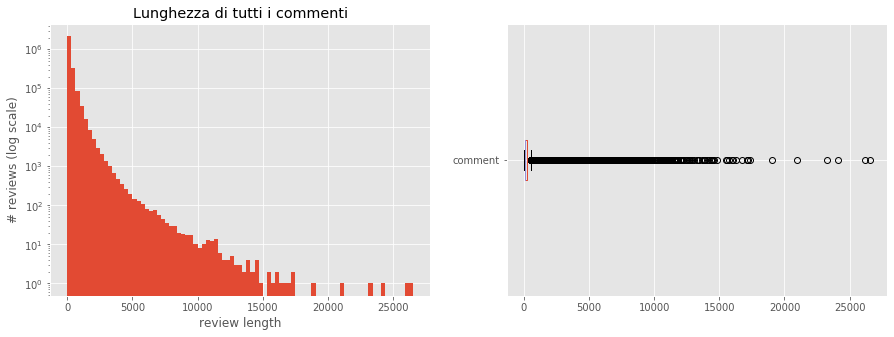

In [11]:
plt.figure(figsize=(15,5))

# First subplot with all data
plt.subplot(121)
plt.title("Lunghezza di tutti i commenti")
plt.xlabel("review length")
plt.ylabel("# reviews (log scale)")
lengths.hist(bins=85, log=True);

plt.subplot(122)
lengths.plot.box(vert=False);

### 4.2. Distribuzione dei voti

Si può osservare come la maggior parte dei voti sia distribuita fra 6 e 8. Solo una porzione più piccola è fortemente negativa (< 4).

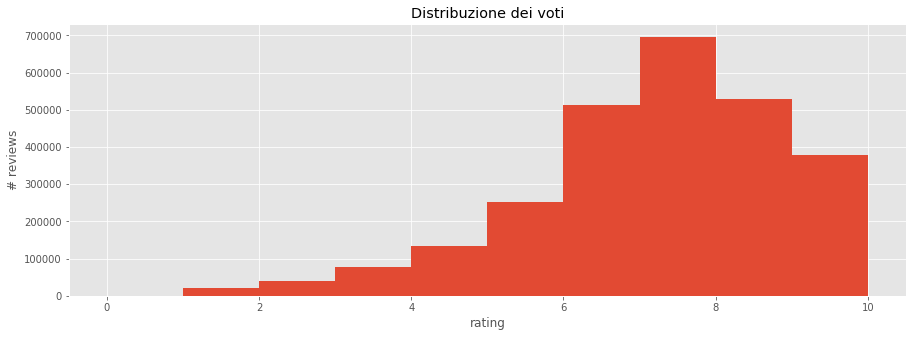

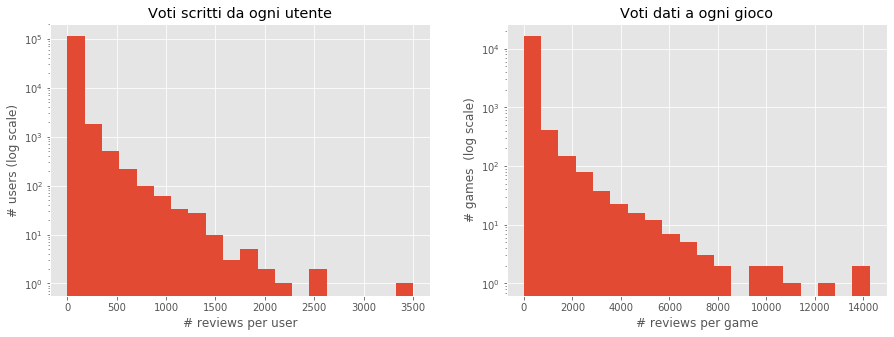

In [12]:
reviews_by_user = reviews.groupby(by="user").count()
reviews_by_game = reviews.groupby(by="ID").count()

plt.figure(figsize=(15,5))
plt.title("Distribuzione dei voti")
plt.xlabel("rating")
plt.ylabel("# reviews")
reviews["rating"].hist(bins=10);

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Voti scritti da ogni utente")
plt.xlabel("# reviews per user")
plt.ylabel("# users (log scale)")
reviews_by_user["rating"].hist(bins=20, log=True);

plt.subplot(122)
plt.title("Voti dati a ogni gioco")
plt.xlabel("# reviews per game")
plt.ylabel("# games  (log scale)")
reviews_by_game["rating"].hist(bins=20, log=True);

La maggior parte degli utenti ha dato meno di 20 valutazioni, mentre la maggior parte dei giochi ha ricevuto meno di un centinaio di recensioni. In generale, quindi, un utente fornisce poche valutazioni e sono pochi gli utenti più attivi che hanno recensito molti giochi; il numero massimo di recensioni scritte da un solo utente è di 3503!

In [13]:
aggr = pd.concat([pd.DataFrame(reviews_by_user["rating"].describe(percentiles=[0.25,0.5,0.75,0.9])), 
                  pd.DataFrame(reviews_by_game["rating"].describe(percentiles=[0.25,0.5,0.75,0.9]))], axis=1)
aggr.columns = ["reviews by user", "reviews by game"]
aggr

,reviews by user,reviews by game
count,115243.000000,17058.000000
mean,22.888644,154.634541
std,72.908512,515.450229
min,1.000000,1.000000
25%,1.000000,15.000000
50%,3.000000,31.000000
75%,15.000000,91.000000
90%,51.000000,306.000000
max,3503.000000,14267.000000


### 4.3. Possibili correlazioni fra variabili
In seguito si analizzano i dati per vedere se sono presenti nel dataset `games` eventuali correlazioni, che potrebbero essere sfruttate da semplici algoritmi di regressione senza ricorrere al NLP (per esempio fra il numero di recensioni e il voto ricevuto da un gioco). Dato che la colonna `Rank` del dataframe viene utilizzata per ordinare i giochi in base alla valutazione questa sarebbe ovviamente fortemente correlata con le misure `Bayes average` e `Average`, quindi viene scartata.

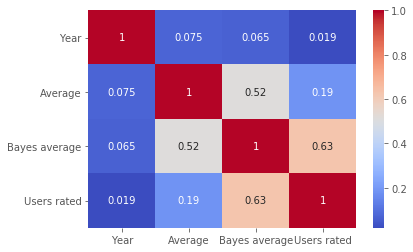

In [14]:
sns.heatmap(games.drop(["ID", "Rank"], axis=1).corr(), annot=True, cmap='coolwarm');

Ovviamente la media e la media di Bayes sono fra loro correlate, tuttavia tale correlazione non può essere sfruttata in quanto rappresentano entrambe un dato che si vuole prevedere e non si conosce a priori: la valutazione del gioco.
La stessa correlazione positiva fra il numero di utenti che hanno valutato un gioco e la media di Bayes è da considerarsi non particolarmente significativa proprio perché, in virtù della definizione stessa di tale metrica, questa sarà più bassa per giochi con poche recensioni. 

### 4.4. Pulizia dei dataset
Per ridurre la dimensione dei dataset sono stati seguiti i seguenti passi:
- Rimozione di tutti i giochi per i quali sono presenti meno di 15 recensioni
- Rimozione di tutti gli utenti che hanno lasciato meno di 50 recensioni 
- Rimozione di tutti i commenti più corti di 52 caratteri (25° percentile)
- Rimozione di tutte le recensioni riferite a un gioco o un utente eliminato

Si fa l'assunzione semplificativa (non necessariamente vera) che le recensioni degli utenti che ne hanno scritte molte siano più attendibili di utenti casuali che hanno lasciato poche recensioni.

In [15]:
games_to_remove = reviews_by_game[reviews_by_game["rating"] < 15].index
users_to_remove = reviews_by_user[reviews_by_user["rating"] < 50].index
reviews_to_keep = lengths >= 50

games_cleaned = games[~games["ID"].isin(games_to_remove)]
reviews_cleaned = reviews[reviews["ID"].isin(games_cleaned["ID"]) & 
                          (~reviews["user"].isin(users_to_remove)) &
                          reviews_to_keep]

In [16]:
print(f"Riduzione del {100 * (len(games) - len(games_cleaned)) / len(games):.2f}%")
print(f"Numero di recensioni nel dataset modificato: {len(games_cleaned)}")

Riduzione del 24.01%
Numero di recensioni nel dataset modificato: 12967


In [17]:
print(f"Riduzione del {100 * (len(reviews) - len(reviews_cleaned)) / len(reviews):.2f}%")
print(f"Numero di recensioni nel dataset modificato: {len(reviews_cleaned)}")

Riduzione del 45.09%
Numero di recensioni nel dataset modificato: 1448348


In questo modo il numero di recensioni è stato ridotto all'incirca del 45%.

***
# NLP

In seguito verranno analizzate nel dettaglio le recensioni da un punto di vista dell'analisi del linguaggio naturale. Vengono innanzitutto modificate tutte le recensioni applicandovi la funzione di pulizia del testo riportata [sopra](#3.-Pulizia-delle-recensioni).

In [18]:
reviews_cleaned["comment"] = reviews_cleaned["comment"].apply(lambda x: clean_text(x))

A questo punto potrebbe essere necessario rimuovere altre recensioni la cui lunghezza, dopo la pulizia, sia scesa sotto una certa soglia. In particolare tutte le recensioni che adottano alfabeti diversi da quello inglese saranno state ridotte ad una stringa vuota.

In [19]:
lengths_cleaned = reviews_cleaned["comment"].apply(lambda x: len(x))
reviews_cleaned = reviews_cleaned[lengths_cleaned >= 50]

## 1. Parole più ricorrenti
Viene inizialmente fatta un'analisi delle parole più ricorrenti. A tale scopo viene utilizzato un semplice `CountVectorizer` senza uso del tokenizer di `nltk`, lemmatizzazione o stemming. Viene considerato un campione di 100'000 commenti per ridurre i tempi di esecuzione, l'analisi è comunque indicativa delle parole più ricorrenti.

In [20]:
comments_to_analyse = reviews_cleaned["comment"].sample(100_000, random_state=11)
count_vectorizer = CountVectorizer()
vecs = count_vectorizer.fit_transform(comments_to_analyse)

In [21]:
def top_k_words(vecs, words, k=10):
    """Return the top k words from a sparse matrix obtained through a vectorizer.
    
       Parameters:
         - vecs: the (sparse) matrix representing the vectorized words
         - words: the list of words corresponding to each row of the matrix
         
       Returns:
         A sorted list of pairs (word, counts)."""
    words_count = vecs.sum(axis=0)
    words_count = [(word, words_count[0, i]) for i, word in enumerate(words)]
    return sorted(words_count, key = lambda x: x[1], reverse=True)[:(k if k > 0 else None)]

In [22]:
top_k_words(vecs, count_vectorizer.get_feature_names())

[('the', 249990),
 ('to', 142466),
 ('and', 126665),
 ('game', 126347),
 ('of', 113095),
 ('it', 89696),
 ('is', 85563),
 ('this', 64661),
 ('but', 58111),
 ('in', 56477)]

Si può osservare come, delle 10 parole più utilizzate, la maggior parte siano delle *stopwords*. Per questo, il passo successivo dell'analisi consiste nella loro rimozione:

In [23]:
count_vectorizer = CountVectorizer(stop_words=nltk.corpus.stopwords.words("english"))
vecs = count_vectorizer.fit_transform(comments_to_analyse)

In [24]:
top_k_words(vecs, count_vectorizer.get_feature_names(), 10)

[('game', 126347),
 ('play', 37647),
 ('like', 28149),
 ('one', 25047),
 ('fun', 23591),
 ('games', 20111),
 ('good', 19518),
 ('players', 19331),
 ('really', 18653),
 ('cards', 17958)]

Si possono notare alcune parole molto ricorrenti le quali, considerando che si stanno analizzando recensioni a giochi da tavolo, non aggiungono alcun significato se prese singolarmente (e.g. "game", "play", "games", "cards", "players", ...). Queste, nel caso in cui non vengano utilizzati i bigram, saranno inserite nelle _stopwords_.
Inoltre sono presenti diverse parole con le stesse radici (e.g. "game"/"games", "play"/"player"/"played", ...), in seguito, quindi, si cercherà di capire se l'adozione di stemming può portare a dei vantaggi nella classificazione.

Analizzando le parole meno frequenti si possono notare molti termini con errori o senza senso. Per questo motivo successivamente si verificherà se l'uso di una soglia maggiore per `min_df` possa portare dei vantaggi.

In [25]:
top_k_words(vecs, count_vectorizer.get_feature_names(), -1)[-20:-10]

[('zwemmend', 1),
 ('zwemmers', 1),
 ('zwingend', 1),
 ('zwischenzug', 1),
 ('zwitter', 1),
 ('zwizanego', 1),
 ('zwlf', 1),
 ('zwngen', 1),
 ('zww', 1),
 ('zwycistwa', 1)]

## 2. Analisi dei bigram
Si considerano adesso i bigram per vedere se possono avere informazioni significative.

In [26]:
count_vectorizer = CountVectorizer(stop_words=nltk.corpus.stopwords.words("english"), ngram_range=(2,2))
vecs = count_vectorizer.fit_transform(comments_to_analyse)

In [27]:
top_k_words(vecs, count_vectorizer.get_feature_names(), 10)

[('good game', 2999),
 ('great game', 2609),
 ('game play', 2564),
 ('card game', 2551),
 ('fun game', 2377),
 ('player game', 2123),
 ('like game', 1993),
 ('ive played', 1832),
 ('worker placement', 1691),
 ('play game', 1616)]

Si può notare come ci siano diversi bigram che sembrano essere particolarmente significativi come `"good game"`, `"great game"` o `"fun game"`. In questo caso inserire parole come "game" fra le _stopwords_ porterebbe a perdere tali bigram, per questo motivo sono preparati due set di _stopwords_ distinti.

In [28]:
stopwords_mono = nltk.corpus.stopwords.words("english") + ["game", "games", "player", "players", "play"]
stopwords_bi = nltk.corpus.stopwords.words("english")

***
# Classificazione delle recensioni
Si vuole cercare di capire, partendo dal testo della recensione, se questa sarà sufficiente (con voto $\ge$ 6) o meno. 

Dato che le recensioni sono molto numerose, per ridurre i tempi di esecuzione del notebook, altrimenti troppo lunghi, si è scelto di utilizzare unicamente 50'000 recensioni nella fase di addestramento dei modelli.

Certamente, sfruttando l'intero dataset si potrebbero ottenere precisioni maggiori al prezzo di aumentare notevolmente i tempi di esecuzione (prove sull'intero dataset hanno richiesto quasi un'ora per eseguire la tokenizzazione e stemming di tutti i commenti). Vista la grande disponibilità di dati si è scelto inoltre di mantenere un test set di dimensione elevata per cercare di mantenere piccolo l'intervallo di confidenza.

In [29]:
# Split into train and validation set
X_train, X_val, y_train, y_val = train_test_split(reviews_cleaned["comment"], 
                                                  reviews_cleaned["rating"], 
                                                  train_size=50_000,
                                                  test_size=100_000, 
                                                  random_state=11)
# Give a label to each rating
y_train = y_train.apply(lambda x: "bad" if x < 6 else "good")
y_val = y_val.apply(lambda x: "bad" if x < 6 else "good")

Si può osservare come la distribuzione fra classi sia sbilanciata a favore di quelle positive:

good    0.77958
bad     0.22042
Name: rating, dtype: float64


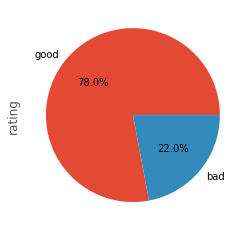

In [30]:
print(y_train.value_counts(normalize=True))
y_train.value_counts(normalize=True).plot.pie(autopct="%1.1f%%");

## 1. Valutazione dei modelli
Per valutare i vari modelli viene realizzata una funzione che restituisce un dizionario contenente:
   - `score`: score del modello (percentuale di istanze classificate correttamente)
   - `score_min`: l'estremo inferiore dell'intervallo di confidenza per lo score 
   - `score_max`: l'estremo superiore dell'intervallo di confidenza per lo score
   - `f1`: f1-score del modello (media degli f1-score per entrambe le classi)
   - `f1_min`: l'estremo inferiore dell'intervallo di confidenza per l' f1-score
   - `f1_max`: l'estremo superiore dell'intervallo di confidenza per l' f1-score
   
Gli intervalli di confidenza vengono calcolati con confidenza al 95%. 
I modelli sono confrontati fra loro sempre allo stesso livello di confidenza con la funzione `diff_interval` che calcola un'intervallo; se in questo è presente lo 0 allora la differenza fra i modelli non sarà significativa.

In [31]:
def conf_interval(a, N, Z=1.96):
    c = (2 * N * a + Z**2) / (2 * (N + Z**2))
    d = Z * np.sqrt(Z**2 + 4*N*a - 4*N*a**2) / (2 * (N + Z**2))
    return c - d, c + d

def model_metrics(y_pred, y_val, Z=1.96, verbose=True):
    """Return a Python dict containing informations about the model used to obtain y_pred.
    
       Parameters:
         - y_pred: the predicted labels
         - y_val: the actual labels
         - Z: the Z-value corresponding to the confidence level, default is 1.96
              meaning a confidence level of 95%
         - verbose: if True prints the data in the dict
     
       Returns:
         A python dict containing the score, f1-score and corresponding confidence
         intervals for each metric."""
    score = f1_score(y_val, y_pred, average="micro")
    f1 = f1_score(y_val, y_pred, average="macro")
    score_min, score_max = conf_interval(score, len(y_val), Z)
    f1_min, f1_max = conf_interval(f1, len(y_val), Z)
    
    if verbose:
        print("Model metrics:")
        print(f"  - Score:\t{score:.3f} ∈ [{score_min:.3f}, {score_max:.3f}]")
        print(f"  - f1 score:\t{f1:.3f} ∈ [{f1_min:.3f}, {f1_max:.3f}]")
        
    return {
        "score": score,
        "score_min": score_min,
        "score_max": score_max,
        "f1": f1,
        "f1_min": f1_min,
        "f1_max": f1_max
    }

def plot_confusion_matrix(y_pred, y_val, classes):
    cm = confusion_matrix(y_val, y_pred, normalize="true")
    sns.heatmap(cm, square=True, annot=True, cmap="coolwarm", 
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted");
    plt.ylabel("Actual");


def compare_models(model_metrics_1, model_metrics_2, len_1, len_2, Z=1.96):
    """Compare the metrics computed for each model with the given confidence Z.
       
       Parameters:
         - model_metrics_1: the metrics dict of the first model
         - model_metrics_2: the metrics dict of the second model
         - len_1: the length of the validation set used to compute the metrics
                  for the first model
         - len_2: the length of the validation set used to compute the metrics
                  for the second model
         - Z: the Z-value corresponding to the confidence level, default is 1.96
              meaning a confidence level of 95%"""
    for metric in ["score", "f1"]:
        min_range, max_range = diff_interval(model_metrics_1[metric], 
                                             model_metrics_2[metric], 
                                             len_1, len_2, Z)
        relevance = ("non " if 0 > min_range and 0 < max_range else "") + "relevant"
        print(f"{metric}:\t [{min_range:.3f}, {max_range:.3f}] -> {relevance}")
    
def diff_interval(a1, a2, N1, N2, Z=1.96):
    d = abs(a1 - a2)
    sd = np.sqrt(a1 * (1-a1) / N1 + a2 * (1-a2) / N2)
    return d - Z * sd, d + Z * sd

def grid_search_and_eval(model, grid, scoring="f1_macro"):
    """Performs grid search and model evaluation returning the grid search object
       and a Python dict with the computed metrics.
       
       Params:
         - model: the model to perform grid search on
         - grid: the grid search parameters
         - scoring: the scoring method to use when performing grid search
        
       Returns:
         The fitted grid search object and a dict obtained from the function
         'model_metrics'."""
    gs = GridSearchCV(model, grid, cv=3, scoring=scoring, n_jobs=-1)
    gs.fit(X_train, y_train);
    
    preds = gs.predict(X_val)
    best_estimator_metrics = model_metrics(preds, y_val)
    plot_confusion_matrix(preds, y_val, gs.classes_)

    return gs, best_estimator_metrics

## 2. Classificazione
Viene innanzitutto realizzato un metodo di regressione logistica. Viene fatta una ricerca degli iperparametri per capire quale sia il miglior grado e tipo di regolarizzazione e se modificare il peso delle classi possa portare a dei miglioramenti.

Model metrics:
  - Score:	0.814 ∈ [0.812, 0.816]
  - f1 score:	0.650 ∈ [0.647, 0.653]


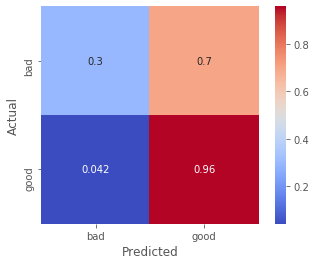

In [32]:
model = Pipeline([
    ("vectorizer", TfidfVectorizer(stop_words=stopwords_mono)),
    ("classifier", LogisticRegression(random_state=11, solver="saga"))
])
grid = [{
    "vectorizer__min_df": [50, 100],
    "classifier__penalty": ["l1", "l2"],
    "classifier__C": [0.01, 0.1, 1],
    "classifier__class_weight": [{"bad": 3, "good":1}, None]
}]
logreg_score, logreg_score_metrics = grid_search_and_eval(model, grid, "accuracy")

In [33]:
logreg_score.best_params_

{'classifier__C': 1,
 'classifier__class_weight': None,
 'classifier__penalty': 'l2',
 'vectorizer__min_df': 50}

Nonostante il modello abbia un buono score, questo non è indicativo della sua effettiva bontà in quanto il 70% delle recensioni negative viene classificato in maniera errata. Si preferisce dunque favorire l'ottimizzazione dell'`f1-score` che forzerà il modello a migliorare la classificazione delle recensioni negative.

L'idea alla base di questa scelta è che, ai fini di eventuali indagini, è più importante riuscire a identificare correttamente recensioni negative dalle quali ottenere informazioni utili ad apprendere aspetti da migliorare nel proprio prodotto o in prodotti futuri (e.g. una meccanica di gioco che non è stata apprezzata, la componentistica inadeguata,...).

### 2.1. Con regressione logistica e monogram
Un secondo modello viene quindi addestrato utilizzando solo i monogram e minimizzando l'`f1-score`.

Model metrics:
  - Score:	0.765 ∈ [0.763, 0.768]
  - f1 score:	0.692 ∈ [0.689, 0.694]


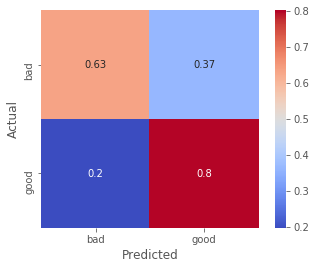

In [34]:
model = Pipeline([
    ("vectorizer", TfidfVectorizer(stop_words=stopwords_mono)),
    ("classifier", LogisticRegression(random_state=11, solver="saga"))
])
grid = [{
    "vectorizer__min_df": [50, 100],
    "classifier__penalty": ["l1", "l2"],
    "classifier__C": [0.01, 0.1, 1],
    "classifier__class_weight": [{"bad": 3, "good":1}, None]
}]
regr_model_mono, regr_model_mono_metrics = grid_search_and_eval(model, grid)

Effettuando un confronto fra i due modelli si può notare come le differenze siano entrambe statisticamente significative. Quindi, come ci si sarebbe potuto attendere, il modello che ottimizza l'`f1-score` si comporta effettivamente meglio nella classificazione delle recensioni negative a discapito dello score generale. Dato che in questo caso si dà maggior importanza alla capacità di classificare correttamente **tutti** i tipi di recensione, si predilige il secondo modello.

In [35]:
regr_model_mono.best_params_

{'classifier__C': 0.1,
 'classifier__class_weight': {'bad': 3, 'good': 1},
 'classifier__penalty': 'l2',
 'vectorizer__min_df': 50}

In [36]:
compare_models(logreg_score_metrics, regr_model_mono_metrics, len(y_train), len(y_train))

score:	 [0.044, 0.054] -> relevant
f1:	 [0.036, 0.047] -> relevant


### 2.2. Con regressione logistica e bigram
Viene addestrato un ulteriore modello utilizzando i bigram per verificare che la loro adozione comporti degli effettivi miglioramenti:

Model metrics:
  - Score:	0.773 ∈ [0.770, 0.775]
  - f1 score:	0.698 ∈ [0.695, 0.701]


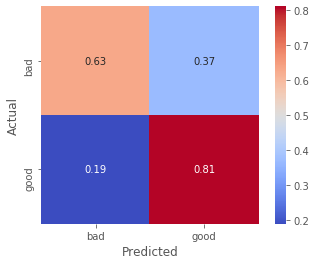

In [37]:
model = Pipeline([
    ("vect", TfidfVectorizer(stop_words=stopwords_bi, ngram_range=(1,2))),
    ("regr", LogisticRegression(random_state=11, solver="saga"))
])
grid = [{
    "vect__min_df": [50, 100],
    "regr__penalty": ["l1", "l2"],
    "regr__C": [0.01, 0.1, 1],
    "regr__class_weight": [{"bad": 3, "good":1}, None]
}]
regr_model_bi, regr_model_bi_metrics = grid_search_and_eval(model, grid)

In [38]:
regr_model_bi.best_params_

{'regr__C': 0.1,
 'regr__class_weight': {'bad': 3, 'good': 1},
 'regr__penalty': 'l2',
 'vect__min_df': 50}

Il modello che fa uso dei bigram sembra essere migliore rispetto al primo, con una leggera crescita di entrambe le metriche. Per stabilire se questa differenza è statisticamente significativa viene calcolato l'intervallo di differenza fra i due modelli:

In [39]:
compare_models(regr_model_mono_metrics, regr_model_bi_metrics, len(y_train), len(y_train))

score:	 [0.002, 0.012] -> relevant
f1:	 [0.001, 0.012] -> relevant


Poichè l'intervallo non contiene lo 0 la differenza è statisticamente significativa e si può considerare il modello che fa uso dei bigram migliore rispetto a quello che usa unicamente le singole parole.

### 2.3. Con regressione logistica e stemming
Per le osservazioni fatte [precedentemente](#1.-Parole-più-ricorrenti) si vuole scoprire se, tramite l'applicazione dello stemming, si possono ottenere risultati migliori. Il tokenizer utilizzato è quello fornito da `nltk`. Dato che l'operazione di stemming e tokenizzazione richiede più tempo si riducono le possibili alternative per la grid search limitando la scelta fra i pesi da dare alle diverse classi.

In [40]:
ps = PorterStemmer()
def tokenize_stem(text):
    return [ps.stem(word) for word in word_tokenize(text)]

Model metrics:
  - Score:	0.773 ∈ [0.770, 0.775]
  - f1 score:	0.699 ∈ [0.696, 0.702]


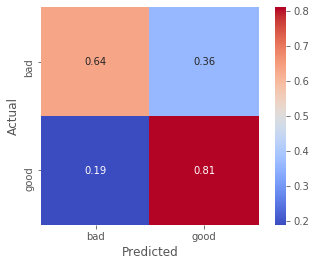

In [41]:
model = Pipeline([
    ("vect", TfidfVectorizer(stop_words=stopwords_bi, ngram_range=(1,2), min_df=50, tokenizer=tokenize_stem)),
    ("regr", LogisticRegression(random_state=11, solver="saga", penalty="l2", C=0.1))
])
grid = [{
    "regr__class_weight": [{"bad": 3, "good":1}, None]
}]
regr_model_stem, regr_model_stem_metrics = grid_search_and_eval(model, grid)

In [42]:
regr_model_stem.best_params_

{'regr__class_weight': {'bad': 3, 'good': 1}}

Il modello presenta un piccolissimo miglioramento che tuttavia non risulta essere statisticamente significativo:

In [43]:
compare_models(regr_model_bi_metrics, regr_model_stem_metrics, len(y_train), len(y_train))

score:	 [-0.005, 0.005] -> non relevant
f1:	 [-0.005, 0.007] -> non relevant


Si può quindi concludere che, operando a regime con un livello di confidenza del 95%, l'uso di stemming non comporta miglioramenti nella classificazione. Quindi, i modelli `regr_model_bi_stem` e `regr_model_bi` risultano essere equivalenti.

### 2.4. Con decision tree
Ho ritenuto potesse essere interessante realizzare un'ulteriore modello utilizzando un decision tree dato che questo argomento è stato solo accennato durante le lezioni. Alcuni riferimenti utili consultati sono stati <a href="https://medium.com/@mohtedibf/indepth-parameter-tuning-for-decision-tree-6753118a03c3">il seguente articolo</a> e la dettagliata <a href="https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html">documentazione di sklearn</a>.

La profondità massima dell'albero viene limitata a 100 per evitare che il processo di addestramento richieda troppo tempo; aumentando tale valore è possibile che i risultati ottenuti possano migliorare leggermente.

Model metrics:
  - Score:	0.732 ∈ [0.730, 0.735]
  - f1 score:	0.620 ∈ [0.617, 0.623]


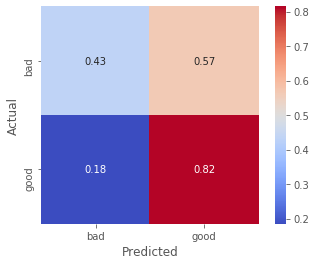

In [44]:
model = Pipeline([
    ("vect", TfidfVectorizer(stop_words=stopwords_bi, ngram_range=(1,2))),
    ("regr", DecisionTreeClassifier(random_state=11, 
                                    max_depth=100,
                                    class_weight={"bad": 3, "good":1}))
])
grid = [{
    "regr__max_features": ["sqrt", None],
    "regr__min_samples_split": [0.1,0.5,1.0],
}]
tree_model, tree_model_metrics = grid_search_and_eval(model, grid)

In [45]:
tree_model.best_params_

{'regr__max_features': None, 'regr__min_samples_split': 0.1}

Il modello allenato presenta uno score e un f1-score inferiori rispetto a quelli del modello già ottenuto tramite regressione logistica. Dato che queste differenze risultano essere statisticamente significative i modelli migliori che verranno considerati in seguito sono `regr_model_bi` e `regr_model_stem`.

In [46]:
compare_models(regr_model_bi_metrics, tree_model_metrics, len(y_train), len(y_train))

score:	 [0.035, 0.046] -> relevant
f1:	 [0.072, 0.083] -> relevant


## 3. Confronto con modelli di controllo
Per verificare che i migliori modelli emersi dalla fase precedente (`regr_model_bi`, `regr_model_stem`) si comportino in maniera soddisfacente, vengono confrontati con due modelli di controllo con confidenza al 99%.

### 3.1. Classificatore "stratified"
Il primo classificatore considerato adotta come strategia quella di predirre le etichette in base alla distribuzione del training set. Come vettorizzatore viene considerato lo stesso utilizzato dal modello migliore individuato dalla grid search, ovvero con `min_df=50` e con uso dei bigram.

Model metrics:
  - Score:	0.656 ∈ [0.654, 0.659]
  - f1 score:	0.498 ∈ [0.495, 0.501]


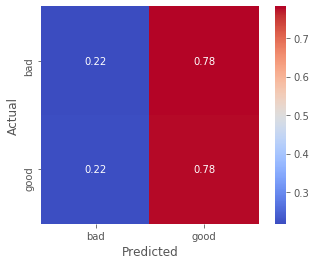

In [47]:
dummy_stratified = Pipeline([
    ("vectorizer", TfidfVectorizer(stop_words=stopwords_bi, ngram_range=(1,2), min_df=50)),
    ("classifier", DummyClassifier(strategy="stratified", random_state=11))
])
dummy_stratified.fit(X_train, y_train);

preds = dummy_stratified.predict(X_val)
dummy_stratified_metrics = model_metrics(preds, y_val)
plot_confusion_matrix(preds, y_val, dummy_stratified.classes_)

Si può osservare come sia lo score che l'f1 score siano minori rispetto a quelli dei modelli migliori. Confrontando le differenze con confidenza al 99% (`Z=2.58`) si può vedere come, a regime, i modelli in considerazione risultino essere sempre migliori:

In [48]:
print("Confronto con modello che fa uso dei bigram:")
compare_models(regr_model_bi_metrics, dummy_stratified_metrics, len(y_train), len(y_train), Z=2.58)

Confronto con modello che fa uso dei bigram:
score:	 [0.109, 0.123] -> relevant
f1:	 [0.192, 0.208] -> relevant


In [49]:
print("Confronto con modello che fa uso dei bigram e di stemming:")
compare_models(regr_model_stem_metrics, dummy_stratified_metrics, len(y_train), len(y_train), Z=2.58)

Confronto con modello che fa uso dei bigram e di stemming:
score:	 [0.109, 0.124] -> relevant
f1:	 [0.193, 0.209] -> relevant


### 3.2. Classificatore costante
Il secondo classificatore utilizzato come confronto è quello che predice sempre la classe che compare con maggior frequenza nei dati di addestramento. 

Model metrics:
  - Score:	0.782 ∈ [0.780, 0.785]
  - f1 score:	0.439 ∈ [0.436, 0.442]


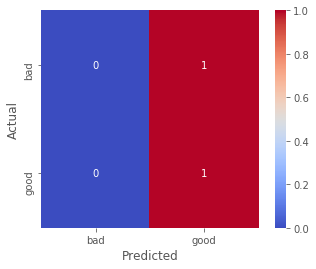

In [50]:
dummy_frequent = Pipeline([
    ("vectorizer", TfidfVectorizer(stop_words=stopwords_bi, ngram_range=(1,2), min_df=50)),
    ("classifier", DummyClassifier(strategy="most_frequent", random_state=11))
])
dummy_frequent.fit(X_train, y_train);

preds = dummy_frequent.predict(X_val)
dummy_frequent_metrics = model_metrics(preds, y_val)
plot_confusion_matrix(preds, y_val, dummy_frequent.classes_)

Si può notare come lo score generico superi leggermente quello del modello trovato (del resto, predicendo sempre la classe `"good"` si otterrà sempre il 78% essendo questa preponderante; d'altro canto, risulta evidente come un tale predittore non possa avere alcuna utilità per applicazioni reali). Tuttavia i modelli trovati, a regime e con confidenza 99%, risultano essere nettamente migliori per quanto riguarda l'f1-score.

In [51]:
print("Confronto con modello che fa uso dei bigram:")
compare_models(regr_model_bi_metrics, dummy_frequent_metrics, len(y_train), len(y_train), Z=2.58)

Confronto con modello che fa uso dei bigram:
score:	 [0.003, 0.016] -> relevant
f1:	 [0.251, 0.267] -> relevant


In [52]:
print("Confronto con modello che fa uso dei bigram e stemming:")
compare_models(regr_model_stem_metrics, dummy_frequent_metrics, len(y_train), len(y_train), Z=2.58)

Confronto con modello che fa uso dei bigram e stemming:
score:	 [0.003, 0.016] -> relevant
f1:	 [0.252, 0.268] -> relevant


***
# Prestazioni sul test set
Stabilito che il modello migliore è `regr_model_bi` (e che `regr_model_stem` è equivalente) viene fatto un test finale su un set di 200'000 commenti che non appartengono nè al training nè al validation set.

In [53]:
# Take a sample of 200'000 comments from those whose index is neither in train nor validation set
comments_test = reviews_cleaned[~reviews_cleaned.index.isin(X_train.index) &
                                ~reviews_cleaned.index.isin(X_val.index)].sample(200_000, random_state=11)
X_test = comments_test["comment"]
# Apply a label to each rating in the test set
y_test = comments_test["rating"].apply(lambda x: "bad" if x < 6 else "good")

In [54]:
preds = regr_model_bi.predict(X_test)
test_scores = model_metrics(preds, y_test, verbose=False)
print(f"score sul test set:\t{test_scores['score']:.3f}, intervallo atteso: [{regr_model_bi_metrics['score_min']:.3f}, {regr_model_bi_metrics['score_max']:.3f}]")
print(f"f1-score sul test set:\t{test_scores['f1']:.3f}, intervallo atteso: [{regr_model_bi_metrics['f1_min']:.3f}, {regr_model_bi_metrics['f1_max']:.3f}]")

score sul test set:	0.774, intervallo atteso: [0.770, 0.775]
f1-score sul test set:	0.701, intervallo atteso: [0.695, 0.701]


L'accuratezza mostrata su dati mai visti in fase di train e validation rimane ampiamente nell'intervallo di confidenza calcolato.

***

# Analisi della conoscenza appresa
Una volta identificati i due modelli migliori è interessante analizzare quanto è stato appreso, ovvero i pesi assegnati a ciascuna parola del dizionario ottenuto dai dati di training. Sono definite due funzioni utili per evitare di ripetere codice nell'analisi dei modelli:

In [55]:
def get_k_words(model, vectorizer, best=True, k=15):
    """Get the k best or worst words based on the weight assigned by a model.
    
       Parameters:
         - model: the model whose coefficients have to be used
         - vectorizer: the vectorizer used by the model whose bag of words has to be evaluated
         - best: if True gets the k best words, otherwise the k worst
         - k: the number of words to be returned
         
       Returns:
         A pandas dataframe containing the words and their corresponding weight."""
    return pd.DataFrame(model.coef_, 
                        columns=vectorizer.get_feature_names()).T.sort_values(by=0, ascending=not best).head(k)
    
def get_reviews_and_game(comment_filter, max_len, min_rating=0, max_rating=10):
    """Returns a dataframe containing filtered comments, the rating and the game the comment
       is about.
       
       Parameters:
         - comment_filter: a function String->Bool that is used to filter the comments
         - max_len: the maximum lenght of the comments
         - min_rating: the minumum rating of the comments
         - max_rating: the maximum rating of the comments
         
       Returns:
         A dataframe containing all the comments shorter than max_len, with a rating 
         between min_rating and max_rating (both are included) and that pass the filtering
         function comment_filter."""
    # Join with games (its index is set to ID in order to perform the join on this value)
    return reviews_cleaned[reviews_cleaned["comment"].apply(comment_filter) &
                (reviews_cleaned["rating"] <= max_rating) & (reviews_cleaned["rating"] >= min_rating) &
                (lengths_cleaned < max_len)].join(games.set_index("ID"), on="ID")[["rating", "comment", "Name"]]

## 1. Modello di regressione con bigrams
Si può osservare, dal modello `regr_model_bi` che le 15 parole migliori sono:

In [56]:
get_k_words(regr_model_bi.best_estimator_.named_steps["regr"],
            regr_model_bi.best_estimator_.named_steps["vect"])

,0
great,3.213837
excellent,3.067736
love,2.886262
solid,2.071743
enjoyed,2.010064
best,1.881886
enjoyable,1.803338
nice,1.793727
favorite,1.772352
well,1.753953


Con una ulteriore analisi si può vedere come siano generalmente apprezzati aspetti come la presenza di strategia e una buona tematizzazione del gioco:

In [57]:
get_k_words(regr_model_bi.best_estimator_.named_steps["regr"],
            regr_model_bi.best_estimator_.named_steps["vect"],
            best=True,
            k=5000).loc[["strategic", "thematic"]]

,0
strategic,1.152915
thematic,1.120018


Se si considerano le parole con peso negativo maggiore si possono incontrare, come ci si sarebbe potuto attendere, diversi aggettivi con accezione negativa:

In [58]:
get_k_words(regr_model_bi.best_estimator_.named_steps["regr"],
            regr_model_bi.best_estimator_.named_steps["vect"],
            best=False)

,0
boring,-4.160714
didnt,-2.305557
random,-2.225761
nothing,-2.130811
dull,-2.044688
kids,-1.969370
kid,-1.838980
isnt,-1.805996
much,-1.760794
bad,-1.731729


Sono valutate in maniera molto negativa le parole "kid" e "kids", osservando le recensioni si può osservare come molti voti negativi siano stati assegnati infatti a giochi rituenuti per bambini.

In [59]:
get_reviews_and_game(lambda x: "kid" in x, 200, max_rating=5).head(10)

,rating,comment,Name
76614,5.0,Great intro to Eurogames but gets old fast The dice rolls can of course make or break you so I dont like the random factor much I kept it as a good intro game with newbies and for kids,Catan
76860,5.0,Also one of my gateway games But is on the memorial part of my gamecollection Now I just play it with the kids once in a while and thats it,Catan
79435,5.0,Just dont find it very interesting Trading with other players often unpleasant Too long for what it is In contrast I rather like Catan Junior with my kids,Catan
80065,5.0,If you dont have an opinion already of Catan you are on the wrong website I will always grab this game if I am playing with somebody who doesnt play board games It is great for kids,Catan
82266,4.0,After finally playing this game Im somewhat amazed that the hobby turned into what it is today Once the kids have burned through this its out,Catan
163902,5.0,I like this game simply because I can play witht the kids Simple as that Otherwise I dont have a peticular feel for this,Carcassonne
163997,5.0,This is also a good game for young kids if you take out the farmers,Carcassonne
165493,5.0,Second Euro game I ever played Not a ton of depth to it but its a good game to play with kids,Carcassonne
166150,5.0,Fun for the first plays Expansions might add a play or Unless you are playing with kids this game is painfully boring,Carcassonne
166442,5.0,Far too luckbased Yes many of the expansions increase strategy but Ive added five and theres still not enough strategy I bring it out for kids,Carcassonne


Da un'ulteriore analisi delle parole valutate negativamente, alcune risultano particolarmente interessanti:

In [60]:
get_k_words(regr_model_bi.best_estimator_.named_steps["regr"],
            regr_model_bi.best_estimator_.named_steps["vect"],
            best=False,
            k=5000).loc[["random", "repetitive", "monopoly"]]

,0
random,-2.225761
repetitive,-1.243061
monopoly,-1.238774


È interessante notare come il Monopoly sia considerato il gioco "brutto" per antonomasia (in maniera condivisibile o meno). Infatti, nonostante il gioco sia molto diffuso, generalmente giocatori con più esperienza ne apprezzano poco le meccaniche troppo dipendenti dal caso. Non stupisce quindi che anche la parola "random" compaia fra quelle valutate più negativamente.

In [61]:
get_reviews_and_game(lambda x: "monopoly" in x, 300, max_rating=5).head(10)

,rating,comment,Name
76693,5.0,and people call risk a dice fest one die roll decides your resources i would rather play monopoly,Catan
76796,5.0,My first non traditional board game ie non warconflict based game Ive played this many more times than recorded here Ive since moved on but a great game to play with those used to monopoly or snakes and ladders aka people who think games are for kids,Catan
81541,4.0,If you have bad dice karma dont play However this game takes the concept behind monopoly and expands it in to a gamers game Probably a very good game for introducing the family to more gamer friendly games,Catan
84142,3.0,Overrated Heavy luck elements Rather boring I understand why this game appeals to some but once you get into the hobby there are SO many better options This is like one step above monopoly for me,Catan
448386,2.0,This game will soon have sold as many copies as monopoly and is about as fun Like most classic board games its stunningly boring I will grudgingly play the app version with children or adults with severe cognitive disabilities but thats for their benefit not mine,Ticket to Ride
713380,5.0,Dubbed Monopoly for Angry People Strictly better than monopoly strictly worse than most other things with a similar mechanic Play Le Havre or Agricola instead,Power Grid
810522,4.0,I would never play this game unless its with children A boring slog with a few small rule additions that bring the game up from a to a The reason this game has sold so much is because its like catan its the monopoly of our generation For me that says it all,Ticket to Ride: Europe
1027135,3.0,I dont see the hype the symbols are terrible Id rather play monopoly Although one of our BOP reviewers had a totally different opinion from me that you may want to check out if your interested in the game httpboardofplayingcomarchives,Race for the Galaxy
1282257,5.0,fun social game like monopoly and risk its all about what you can talk the other players into I rarely lose,Munchkin
1287451,4.0,This is the game that introduced me to stuff more complicated than monopoly It started out really great but now I cant stand to play it There are just so many better games,Munchkin


In [62]:
get_reviews_and_game(lambda x: "random" in x, 300, max_rating=5).head(10)

,rating,comment,Name
76135,5.0,Yeah my first germanstylegame Its fun its fast and requires some thinking The dicerandomness brings the score down a bit though Also its a bit too long with points first player to points usually wins and its too dificult to catch up with lucky players getting ahead,Catan
76238,5.0,A very overrated game Far too luck driven You dont roll the dice nearly enough to flatten out the randomness This ones filed with Monopoly in the bin,Catan
76412,5.0,The random element of dice roles just plain bugs me,Catan
76525,5.0,Nice some player interaction Unfortunately it is rather random and some players can be effectively prevented from winning early on and yet have to play out the whole game The trading aspect is nice but with one person in a dominant board position it decreases greatly in importance,Catan
76614,5.0,Great intro to Eurogames but gets old fast The dice rolls can of course make or break you so I dont like the random factor much I kept it as a good intro game with newbies and for kids,Catan
76653,5.0,Too random for my tastes but a good introduction to more serious games Prefer to play with Cities Knights,Catan
76672,5.0,I do not enjoy the randomness in this game compared to the other Euro games Still a good game that I would recommend as a gateway game depending on the person,Catan
76971,5.0,ODd on this game in college and even then the random got to me There are just so few meaningful decisions This is still the best of the Catan games though,Catan
77313,5.0,Im finding that Im not a big fan of negotiation games and between that and the randomness added by the die rolls on this one Catan isnt a favorite of mine,Catan
77437,5.0,A solid game especially for people just entering the eurogame market For more experienced gamers the random dice roll mechanic is a dealbreaker,Catan


In [63]:
get_reviews_and_game(lambda x: "repetitive" in x, 300, max_rating=5).head(10)

,rating,comment,Name
163876,5.0,Im played out on Carcassonne Ill admit part of that is Im sick of seeing expansionsvariantsetc taking up shelf space at the shops but part of it is just repetitive game play,Carcassonne
164134,5.0,Considered as one of the better Eurogames but to me Its too repetitive Player interaction is limited The farmers can make too much difference Players choices have insufficient impact on the game,Carcassonne
166403,5.0,Classic gateway to eurogames Tiles placing classic Quite repetitive mechanics With much luck involved Player count performance NO,Carcassonne
167011,4.5,okay to play occasionally but if you play this more then once every other week it gets mundane and boring fast even if you buy all the add ons Its not a bad game for people new to board games just that it feels a little repetitive to me,Carcassonne
167013,4.5,Doesnt do much for me at all Its nice to look at has a cooperative element in building the common map and is easy to pick up except for farmer scoring but its just not that much fun Obviously a lot of people love it but to me its rather boring and repetitive,Carcassonne
168247,3.5,Scoring the Game I experienced it as a new gamer and even then it did little for me Got repetitive after second playthrough For the first half of the game you place tiles where appropriate for the second half you count scores,Carcassonne
248415,5.0,My favourite gateway game Its easy for people not used to playing board games to play a cooperative game and this one has the right balance of difficulty That said it does become repetitive with repeated games and has the danger of one person controlling the strategy,Pandemic
317788,5.0,Quick simple cardlaying game Improved with the expansions Feels too solitaire and binary in decisionmaking Quickly becomes repetitive,7 Wonders
319233,4.0,This is a nifty game crammed in a minute package It is enjoyable but I need to play it with more than and players because as of right now it is extremely repetitive and quite stale,7 Wonders
319721,4.0,We used to play this a lot I guess we lost interest It gets repetitive and it isnt specially fun It is long also,7 Wonders


## 2. Modello di regressione con bigrams e stemming
Anche in questo modello si possono notare alcuni aspetti interessanti, le 15 parole più positivamente valutate dal modello `regr_model_stem` sono:

In [64]:
get_k_words(regr_model_stem.best_estimator_.named_steps["regr"],
            regr_model_stem.best_estimator_.named_steps["vect"])

,0
great,3.247359
excel,2.947844
love,2.742561
enjoy,2.231918
solid,2.098111
expans,1.985526
best,1.868340
favorit,1.866054
fun,1.841316
nice,1.816964


Sono presenti molte radici in comune col modello precedente, tuttavia si può notare una nuova parola interessante: "expans". Analizzando le recensioni si può capire meglio il significato di questa radice:

In [65]:
get_reviews_and_game(lambda x: "expans" in x, 200, min_rating=7)

,rating,comment,Name
148,10.0,The rating is with the player expansion and whether playing Seafahrers or not Without the expansion it is still a I prefer games with more than,Catan
168,10.0,The game and the expansions are brilliant Still one of my top ten games hey maybe we ought to play this tomorrow night,Catan
416,10.0,Played this a lot and burned out Still up for a game now and then if its fast Dont really care for all of the expansions Play with my kids from time to time Rating Suggest,Catan
512,10.0,My favorite all time gameno expansions player Nowadays I like to play fast minutes with experienced players,Catan
783,10.0,Although I like the Cities Knights expansion nothing beats the basic game Perfectly adapts to players with simple variant,Catan
...,...,...,...
13102750,7.0,Good expansion for Mystick Domination I wished the Major Arcana cards would have different abilities in this set so you can pick and choose but whaddyagonnado,Mystick Companion
13132447,7.0,Excellent game Light civ game played with cards Gives you the feeling of civ building expansion conquest and culture Must get professionally produced by a larger company Home made version,Age of Heroes
13154931,7.5,Expensive but extremely beautiful Meanwhile I got the expansion SuperQuintillions as well If you are fond of wooden games and puzzles you should have a closer look,Quintillions
13161996,9.0,Lack of dice only thing preventing me from giving this game my first ever Hopefully the expansion will correct this minor design flaw Really feels like your fighting the Imperial Fleet,"Admiral Ackbar ""It's a TRAP!"" GAME"


Nelle recensioni che utilizzano questa parola si può notare come spesso venga espresso il desiderio di avere un'espansione o come il gioco sia migliorato con l'aggiunta di una espansione. È interessante quindi notare come, grazie al modello di classificazione, si sia potuto evidenziare un trend altrimenti difficile da scoprire leggendo manualmente delle recensioni.

Le parole valutate più negativamente sono in gran parte sovrapponibili con quelle ottenute dal modello che non fa uso di stemming:

In [66]:
get_k_words(regr_model_stem.best_estimator_.named_steps["regr"],
            regr_model_stem.best_estimator_.named_steps["vect"],
            best=False)

,0
bore,-4.173116
kid,-2.441161
didnt,-2.274533
random,-2.165755
dull,-2.121872
noth,-2.074200
much,-1.876761
isnt,-1.791567
dont,-1.763679
idea,-1.755043


***
# Conclusioni
Le grandi dimensioni del dataframe hanno posto alcune sfide, già dalla fase dell'ottimizzazione in memoria dei dati. Tuttavia, l'abbondanza di recensioni ha permesso di estrarre informazioni interessanti. I modelli di classificazione ottenuti hanno mostrato una buona accuratezza, considerando anche il grande sbilanciamento delle classi; infine, grazie al grande numero di recensioni si è potuto mantenere un test set di dimensione sufficiente a ridurre notevolmente gli intervalli di confidenza. 

Nel complesso sono soddisfatto del lavoro svolto e di aver provato a utilizzare un classificatore differente dalla regresione logistica non affrontato a lezione. Dato l'interesse personale per i dati analizzati sarebbe interessante svolgere ulteriori approfondimenti e analisi.

## 1. Possibili sviluppi
Viste le grandi dimensioni del dataframe e il numero di recensioni (anche senza commento oltre 13 milioni) si potrebbe realizzare un sistema di recommendation per giochi da tavolo (model based per non incorrere nella maledizione della dimensionalità).

Invece, per proseguire nell'ambito del NLP, si potrebbe realizzare un sistema che, partendo da una stringa in linguaggio naturale, possa consigliare dei giochi in base alle recensioni positive più somiglianti (l'idea viene dal <a href="https://towardsdatascience.com/perfume-recommendations-using-natural-language-processing-ad3e6736074c">seguente articolo</a> che sfrutta anche LSA).